In [492]:
import numpy as np
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import evaluate_module

In [493]:
# place data is stored 
datapath = "/Users/leonivandijk/Desktop/thesis/pyfiles/MCGA/data/"
AD_MODULE = np.array(pd.read_table(datapath + "saddlebrown.txt", dtype=str, header=None))

# algorithm parameters
min_size = 30
min_gene_overlap = 0.5
deg_threshold = .05
member_threshold = 0.5

## Functions to process the results

In [494]:
def read_ioh_output(folder):
    ioh_output = open("/Users/leonivandijk/Desktop/thesis/pyfiles/results/"+folder+"/IOHprofiler_f10005_module_fitness.json")
    ioh_output = json.load(ioh_output)
    scenarios = ioh_output["scenarios"][0]["runs"]
    print("loading ioh output complete. includes data from", len(scenarios), "runs")
    return scenarios

def summarize_opt_modules(scenarios):
    n_runs = len(scenarios)
    sizes = np.zeros(n_runs)
    overlaps = np.zeros(n_runs)
    correlation = np.zeros(n_runs)
    connectivity = np.zeros(n_runs)
    f = np.zeros(n_runs)
    
    for i in range(n_runs):
        x = np.array(scenarios[i]["best"]["x"])
        sizes[i] = np.sum(x)
        overlaps[i] = (1 - (sum(start_module) - sum(x[start_module.astype(bool)])) / sum(start_module))
        correlation[i], connectivity[i], f[i] = evaluate_module.fitness(x)
        
    print("mean best-module size:", np.mean(sizes))
    print("mean gene overlap with initial module:", np.mean(overlaps))
    print("mean correlation:", np.mean(correlation))
    print("mean connectivity:", np.mean(connectivity))
    print("mean fitness value:", np.mean(f))

def opt_modules_genes(scenarios):
    n_runs = len(scenarios)
    best_modules = np.zeros(shape=(n_runs, len(search_space)))
    
    for i in range(n_runs):
        best_modules[i,] = scenarios[i]["best"]["x"]
        
    best_modules_frame = pd.DataFrame(best_modules)
    best_modules_frame.columns = search_space
    
    gene_counts = best_modules_frame.sum().sort_values(ascending=False)
    distribution = pd.DataFrame(gene_counts, columns=['count'])
    distribution = distribution.reset_index().groupby('count').agg(lambda x: x.nunique())
    return gene_counts, distribution

def encode_solution(gene_list):
    solution = np.zeros(shape=search_space.shape, dtype=int)
    for i in gene_list:
        index = np.where(search_space == i)
        solution[index] = 1
    return solution

## Results from optimizing the AD module in the HD network

In [ ]:
# load GCN information (this takes a few mins)
expr_mat = pd.read_csv(datapath + "EXPRMAT_HD.csv", delimiter=';')
tom = pd.read_csv(datapath + "TOM_HD.csv", delimiter=';')
pheno = np.loadtxt(datapath + "PHENO_HD.csv", delimiter='\t', usecols=1, skiprows=1, dtype=int)
degs = pd.read_csv(datapath + "result_deseq2_15984.csv", delimiter='\t', index_col=0)

evaluate_module.expr_mat = expr_mat
evaluate_module.tom = tom
evaluate_module.pheno = pheno
evaluate_module.degs = degs

search_space = evaluate_module.create_searchspace(degs=degs)

# make data-matrices smaller for efficient memory use
expr_mat = np.array(expr_mat.loc[:, search_space])
tom = np.array(tom.loc[search_space, search_space])
max_tom = np.max(np.triu(tom, k=1))

evaluate_module.expr_mat = expr_mat
evaluate_module.tom = tom
evaluate_module.max_tom = max_tom

start_module = np.zeros(shape=search_space.shape, dtype=int)
for i in AD_MODULE:
    index = np.where(search_space == i)
    start_module[index] = 1
start_module_size = sum(start_module)

evaluate_module.start_module = start_module
evaluate_module.start_module_size = start_module_size
print("loading done")

In [ ]:
# see if all AD module genes were included in the search space
filtered_genes_hd = []
for gene in AD_MODULE[:,0]:
    if gene not in search_space:
        filtered_genes_hd.append(gene)

#### RUNNING THE NEXT CELL WILL GIVE YOU THE OPTIMIZED GENE SET for HD:

In [ ]:
# load the results
HD = read_ioh_output("final-runs/HD")
summarize_opt_modules(HD)

# analyse gene occurrence in best-found-modules
counts_per_gene, counts_distribution =opt_modules_genes(HD)
HD_counts = pd.DataFrame(counts_per_gene)
HD_counts.columns = ["count"]

# construct gene list that is the optimized result for myelination in HD
HD_OPT_RESULT = list(HD_counts[HD_counts['count']>94].index)

# print how many genes are in the optimized module
print("number of genes in the optimized module:", len(HD_OPT_RESULT))

# print the statistics of the optimized solution
print("fitness of the module directly after transfer:", evaluate_module.fitness(start_module))
evaluate_module.min_gene_overlap = 0
print("fitness of the module after optimization in HD network:", evaluate_module.fitness(encode_solution(HD_OPT_RESULT)))

## scripts used to study AD (data not included)

In [541]:
# load GCN information (this takes a few mins)
expr_mat = pd.read_csv(datapath + "EXPRMAT_AD.csv", delimiter=';')
tom = pd.read_csv(datapath + "TOM_AD.csv", delimiter=';')
pheno = np.loadtxt(datapath + "PHENO_AD.csv", delimiter=';', usecols=1, skiprows=1, dtype=int)
degs = pd.read_csv(datapath + "results_deseq2_15385.csv", delimiter='\t', index_col=0)

evaluate_module.expr_mat = expr_mat
evaluate_module.tom = tom
evaluate_module.pheno = pheno
evaluate_module.degs = degs

search_space = evaluate_module.create_searchspace(degs=degs)

# make data-matrices smaller for efficient memory use
expr_mat = np.array(expr_mat.loc[:, search_space])
tom = np.array(tom.loc[search_space, search_space])
max_tom = np.max(np.triu(tom, k=1))

evaluate_module.expr_mat = expr_mat
evaluate_module.tom = tom
evaluate_module.max_tom = max_tom

start_module = np.zeros(shape=search_space.shape, dtype=int)
for i in AD_MODULE:
    index = np.where(search_space == i)
    start_module[index] = 1
start_module_size = sum(start_module)

evaluate_module.start_module = start_module
evaluate_module.start_module_size = start_module_size
print("loading done")

loading done


In [ ]:
# see if all AD module genes were included in the search space
filtered_genes_ad = []
for gene in AD_MODULE[:,0]:
    if gene not in search_space:
        filtered_genes_ad.append(gene)

### Best Found Solutions

In [496]:
#load the results
AD = read_ioh_output("final-runs/AD")
summarize_opt_modules(AD)

# analyse gene occurrence in best-found-modules
counts_per_gene, counts_distribution =opt_modules_genes(AD)
AD_counts = pd.DataFrame(counts_per_gene)
AD_counts.columns = ["count"]

# construct gene list that is the optimized result for myelination in AD
AD_OPT_RESULT = list(AD_counts[AD_counts['count']>94].index)

# print how many genes are in the optimized module
print("number of genes in the optimized module:", len(AD_OPT_RESULT))

# print the statistics of the optimized solution
evaluate_module.fitness(start_module)
evaluate_module.min_gene_overlap = 0
evaluate_module.fitness(encode_solution(AD_OPT_RESULT))

loading ioh output complete. includes data from 100 runs


## Comparing AD and HD opt results

In [671]:
# identify shared genes among optimized modules

overlapping_genes = list(set(AD_OPT_RESULT).intersection(set(HD_OPT_RESULT)))

overlapping_genes = pd.DataFrame(overlapping_genes)
overlapping_genes.columns = ['id']
overlapping_genes = overlapping_genes.set_index('id')
overlapping_genes = overlapping_genes.merge(mapping, left_index=True, right_index=True, how='left')
overlapping_genes = overlapping_genes.sort_values('name')

In [667]:
# load files with degs
degs_ad = pd.read_csv(datapath + "results_deseq2_15385.csv", delimiter='\t', index_col=0)
degs_hd = pd.read_csv(datapath + "result_deseq2_15984.csv", delimiter='\t', index_col=0)

In [879]:
# comparing connectivity patterns between the shared genes
# you need to save the co-expression networks for this

GCN_AD = pd.read_csv(datapath+"GCN_AD.csv", index_col=0)
ADmod_connectivity = GCN_AD.loc[AD_OPT_RESULT, AD_OPT_RESULT]
K_in_AD = pd.DataFrame((ADmod_connectivity.sum(axis=1) -1))
K_in_AD.columns = ['in-degree-AD']

GCN_HD = pd.read_csv(datapath+"GCN_HD.csv", index_col=0)
HDmod_connectivity = GCN_HD.loc[overlapping_genes.index, overlapping_genes.index]
K_in_HD = pd.DataFrame(HDmod_connectivity.sum(axis=1) -1)
K_in_HD.columns = ['in-degree-HD']

In [885]:
# find hub nodes
K_in_AD.sort_values('in-degree-AD', ascending=False).head(20)

,in-degree-AD
ENSG00000070214,11.477387
ENSG00000114541,11.463587
ENSG00000124920,11.317243
ENSG00000147488,11.253552
ENSG00000136541,10.662957
ENSG00000174607,10.410149
ENSG00000065809,10.044010
ENSG00000184144,9.847159
ENSG00000164161,9.136334
ENSG00000103089,9.091408


In [760]:
overlapping_genes = overlapping_genes.merge(K_in_AD, left_index=True, right_index=True)
overlapping_genes = overlapping_genes.merge(K_in_HD, left_index=True, right_index=True)

In [804]:
def compute_edges(gene_list, GCN):
    rows = []
    genepairs = list(combinations(gene_list, 2))
    edge_info=[]
    for pair in genepairs:
        rows.append({'source': pair[0], 'target': pair[1], 'weight': GCN.loc[pair[0], pair[1]]})
        edge_info.append(pair[0]+' (interacts with) '+pair[1])
    edges = pd.DataFrame(rows, columns=['source', 'target', 'weight'])
    return edges

In [817]:
edges_hd_og = compute_edges(overlapping_genes.index, GCN_HD)
edges_ad_og = compute_edges(overlapping_genes.index, GCN_AD)
edges = edges_hd_og.set_index(['source', 'target'])
edges.columns = ['weight_hd']
edges = edges.merge(edges_ad_og.set_index(['source', 'target']), left_index=True, right_index=True)
edges.columns = ['weight_hd', 'weight_ad']
edges['diff']=edges.weight_hd - edges.weight_ad

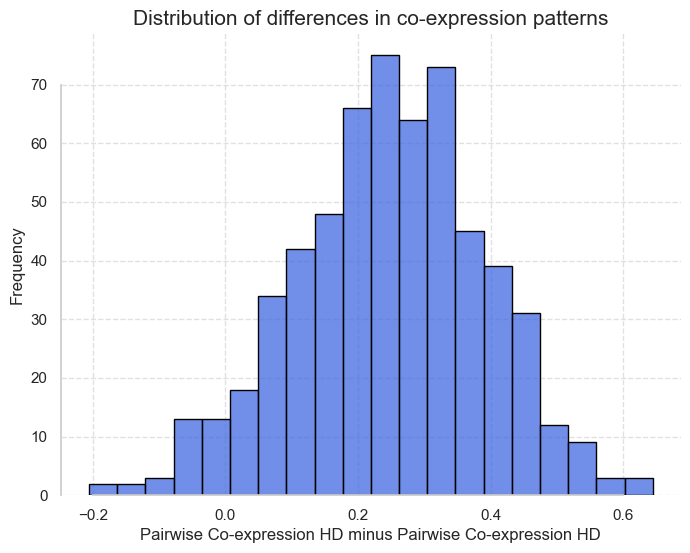

In [829]:
sns.set(style="whitegrid")
# Increase font size for readability in a thesis
plt.rcParams.update({'font.size': 16})

# Create a figure and axis object
plt.figure(figsize=(8, 6))

# Create the histogram
sns.histplot(edges['diff'], bins=20, kde=False, color='royalblue', edgecolor='black')

# Add title and labels
plt.title('Distribution of differences in co-expression patterns', fontsize=15)
plt.xlabel('Pairwise Co-expression HD minus Pairwise Co-expression HD')
plt.ylabel('Frequency')

# Customize the grid and spines for a cleaner look
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine(trim=True)

# Show the plot
plt.show()

In [848]:
# find gene-pairs that have strong change in co-expression
edges.sort_values('diff', ascending=True).head(20)

weight_hd  weight_ad      diff
source          target                                         
ENSG00000126822 ENSG00000147488   0.084601   0.290148 -0.205547
ENSG00000164161 ENSG00000126822   0.049384   0.218313 -0.168928
ENSG00000176658 ENSG00000174607   0.080961   0.233850 -0.152889
ENSG00000126822 ENSG00000123560   0.116411   0.260365 -0.143954
                ENSG00000174607   0.064843   0.164532 -0.099689
ENSG00000136541 ENSG00000126822   0.122553   0.213030 -0.090477
ENSG00000126822 ENSG00000169247   0.167126   0.252806 -0.085680
ENSG00000136960 ENSG00000126822   0.109694   0.184272 -0.074578
ENSG00000176658 ENSG00000091513   0.062331   0.134887 -0.072556
ENSG00000184144 ENSG00000176658   0.142154   0.212789 -0.070635
ENSG00000126822 ENSG00000080815   0.087296   0.157443 -0.070147
ENSG00000170775 ENSG00000126822   0.136120   0.204171 -0.068051
ENSG00000173786 ENSG00000164161   0.171768   0.237657 -0.065890
ENSG00000176658 ENSG00000147488   0.085768   0.151565 -0.065796
ENSG00000184144 ENSG00000174607   0.291377   0.356010 -0.064633
ENSG00000126860 ENSG00000126822   0.038755   0.103125 -0.064370
ENSG00000184144 ENSG00000164161   0.157484   0.216504 -0.059021
ENSG00000126822 ENSG00000176381   0.080300   0.138904 -0.058604
                ENSG00000141540   0.225958   0.282959 -0.057001
ENSG00000184144 ENSG00000126860   0.135765   0.178527 -0.042762

In [ ]:
# plot intermodular connectivity

sns.set(style="whitegrid")
# Increase font size for readability in a thesis
plt.rcParams.update({'font.size': 16})

# Create a figure and axis object
plt.figure(figsize=(8, 6))

# Create the histogram
sns.histplot(K_in_AD['in-degree'], bins=20, kde=False, color='royalblue', edgecolor='black')

# Add title and labels
plt.title('Distribution of Intermodular connectivity', fontsize=15)
plt.xlabel('K-in')
plt.ylabel('Frequency')

# Customize the grid and spines for a cleaner look
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine(trim=True)

# Show the plot
plt.show()

In [ ]:
# plot distribution of co-expression strength

sns.set(style="whitegrid")
# Increase font size for readability in a thesis
plt.rcParams.update({'font.size': 16})

# Create a figure and axis object
plt.figure(figsize=(8, 6))

# Create the histogram
sns.histplot(edges.weight, bins=30, kde=False, color='royalblue', edgecolor='black')

# Add title and labels
plt.title('Distribution of Co-expression strengths', fontsize=15)
plt.xlabel('Co-expression strength')
plt.ylabel('Frequency')

# Customize the grid and spines for a cleaner look
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine(trim=True)

# Show the plot
plt.show()

### differential analyis of gene sets

In [972]:
# find out which genes are added as new information to the module after knowledge transfer
newHD = []
stayHD = []

for gene in HD_OPT_RESULT:
        if gene not in AD_MODULE[:,0]:
            newHD.append(gene)
        else:
            stayHD.append(gene)

In [974]:
newHD = pd.DataFrame(newHD)
newHD.columns = ['id']
newHD = newHD.set_index('id')
newHD = newHD.merge(mapping, left_index=True, right_index=True, how='left')
newHD = newHD.sort_values('name')

In [57]:
newAD = []
stayAD = []

for gene in AD_OPT_RESULT:
    if gene not in HD_OPT_RESULT:
        if gene not in AD_MODULE[:,0]:
            newAD.append(gene)
        else:
            stayAD.append(gene)

In [ ]:
removedboth = []
for gene in AD_MODULE[:,0]:
    if gene not in HD_counts.index:
        if gene not in AD_counts.index:
            removedboth.append(gene)

### merge with G:profiler information to obtain more information on the gene names

In [17]:
mapping = pd.read_csv("/Users/leonivandijk/Desktop/thesis/data/gene_conversion.csv", index_col=0)

In [907]:
pd.DataFrame(K_in_HD['in-degree']).merge(
    mapping, left_index=True, right_index=True).merge(
    degs_hd, left_index=True, right_index=True).sort_values('padj', ascending=True).head(10)

,in-degree,converted_alias,name,description,namespace,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000172508,24.205577,ENSG00000172508,CARNS1,carnosine synthase 1 [Source:HGNC Symbol;Acc:H...,"ARRAYEXPRESS,ENSG",6118.415584,-1.642557,0.307485,-5.341904,9.197557e-08,0.000005
ENSG00000080031,3.511750,ENSG00000080031,PTPRH,protein tyrosine phosphatase receptor type H [...,"ARRAYEXPRESS,ENSG",124.241422,-1.210594,0.244611,-4.949050,7.457673e-07,0.000025
ENSG00000179178,21.325783,ENSG00000179178,TMEM125,transmembrane protein 125 [Source:HGNC Symbol;...,"ARRAYEXPRESS,ENSG",473.054741,-1.399411,0.292803,-4.779361,1.758531e-06,0.000050
ENSG00000122367,17.379244,ENSG00000122367,LDB3,LIM domain binding 3 [Source:HGNC Symbol;Acc:H...,"ARRAYEXPRESS,ENSG",914.051856,-1.160341,0.243470,-4.765843,1.880654e-06,0.000052
ENSG00000186417,14.972084,ENSG00000186417,GLDN,gliomedin [Source:HGNC Symbol;Acc:HGNC:29514],"ARRAYEXPRESS,ENSG",1232.903704,-1.264306,0.269142,-4.697544,2.633083e-06,0.000067
ENSG00000166091,20.248371,ENSG00000166091,CMTM5,CKLF like MARVEL transmembrane domain containi...,"ARRAYEXPRESS,ENSG",873.750078,-1.211794,0.276969,-4.375192,1.213259e-05,0.000223
ENSG00000101049,14.035091,ENSG00000101049,SGK2,serum/glucocorticoid regulated kinase 2 [Sourc...,"ARRAYEXPRESS,ENSG",165.853471,-1.174149,0.271951,-4.317501,1.578057e-05,0.000275
ENSG00000160781,7.967709,ENSG00000160781,PAQR6,progestin and adipoQ receptor family member 6 ...,"ARRAYEXPRESS,ENSG",7927.622479,-0.936720,0.224330,-4.175637,2.971540e-05,0.000437
ENSG00000128645,8.252831,ENSG00000128645,HOXD1,homeobox D1 [Source:HGNC Symbol;Acc:HGNC:5132],"ARRAYEXPRESS,ENSG",52.547780,-1.321682,0.325753,-4.057317,4.963971e-05,0.000653
ENSG00000065675,9.858469,ENSG00000065675,PRKCQ,protein kinase C theta [Source:HGNC Symbol;Acc...,"ARRAYEXPRESS,ENSG",338.819488,-0.690424,0.175391,-3.936482,8.268490e-05,0.000969


In [909]:
pd.DataFrame(K_in_AD['in-degree']).merge(
    mapping, left_index=True, right_index=True).merge(
    degs_ad, left_index=True, right_index=True).sort_values('padj', ascending=True).head(10)

,in-degree,converted_alias,name,description,namespace,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000065809,10.044010,ENSG00000065809,FAM107B,family with sequence similarity 107 member B [...,"ARRAYEXPRESS,ENSG",1020.039296,0.357146,0.062703,5.695850,1.227584e-08,0.000005
ENSG00000011426,5.870770,ENSG00000011426,ANLN,"anillin, actin binding protein [Source:HGNC Sy...","ARRAYEXPRESS,ENSG",1138.472932,0.444841,0.078674,5.654264,1.565155e-08,0.000005
ENSG00000147459,7.935408,ENSG00000147459,DOCK5,dedicator of cytokinesis 5 [Source:HGNC Symbol...,"ARRAYEXPRESS,ENSG",929.933613,0.331343,0.061866,5.355858,8.515135e-08,0.000017
ENSG00000197892,4.137230,ENSG00000197892,KIF13B,kinesin family member 13B [Source:HGNC Symbol;...,"ARRAYEXPRESS,ENSG",697.877572,0.268006,0.050407,5.316836,1.055871e-07,0.000019
ENSG00000016602,4.284881,ENSG00000016602,CLCA4,chloride channel accessory 4 [Source:HGNC Symb...,"ARRAYEXPRESS,ENSG",85.481814,0.403933,0.088094,4.585269,4.534016e-06,0.000190
ENSG00000070214,11.477387,ENSG00000070214,SLC44A1,solute carrier family 44 member 1 [Source:HGNC...,"ARRAYEXPRESS,ENSG",2630.139642,0.221630,0.048858,4.536218,5.727189e-06,0.000219
ENSG00000152689,3.976049,ENSG00000152689,RASGRP3,RAS guanyl releasing protein 3 [Source:HGNC Sy...,"ARRAYEXPRESS,ENSG",274.569035,0.275486,0.062277,4.423538,9.709746e-06,0.000307
ENSG00000057704,5.928347,ENSG00000057704,TMCC3,transmembrane and coiled-coil domain family 3 ...,"ARRAYEXPRESS,ENSG",317.117749,0.253033,0.057215,4.422478,9.757521e-06,0.000307
ENSG00000114993,5.167411,ENSG00000114993,RTKN,rhotekin [Source:HGNC Symbol;Acc:HGNC:10466],"ARRAYEXPRESS,ENSG",1142.242412,0.255093,0.057927,4.403704,1.064183e-05,0.000325
ENSG00000005893,6.973654,ENSG00000005893,LAMP2,lysosomal associated membrane protein 2 [Sourc...,"ARRAYEXPRESS,ENSG",2537.157495,0.238207,0.054594,4.363213,1.281662e-05,0.000373


In [106]:
# also add names to the gene-edge pairs

edges_names = pd.DataFrame(edges).sort_values('weight',ascending=False)
edges_names['name_source'] = edges_names.source.apply(lambda x: mapping.loc[x,:][1])
edges_names['name_target'] = edges_names.target.apply(lambda x: mapping.loc[x,:][1])

In [44]:
# find the pairs with strongest co-expression

pd.DataFrame(edges).sort_values('weight',ascending=False).head(15)

,source,target,weight
1932,ENSG00000136960,ENSG00000123560,0.535768
1418,ENSG00000170775,ENSG00000136960,0.529649
1726,ENSG00000136541,ENSG00000065809,0.465807
1821,ENSG00000065809,ENSG00000070214,0.451883
1447,ENSG00000147488,ENSG00000114541,0.450864
1733,ENSG00000136541,ENSG00000114541,0.450788
1219,ENSG00000174607,ENSG00000011426,0.449280
851,ENSG00000165566,ENSG00000166348,0.439753
1243,ENSG00000174607,ENSG00000136960,0.416267
1244,ENSG00000174607,ENSG00000123560,0.405167


In [349]:
# find genes with highest differential expression

pd.DataFrame(K_in_HD['in-degree']).merge(mapping, left_index=True, right_index=True).merge(
    degs, left_index=True, right_index=True).sort_values("padj", ascending=True).head(20)

,in-degree,converted_alias,name,description,namespace,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ENSG00000172508,24.205577,ENSG00000172508,CARNS1,carnosine synthase 1 [Source:HGNC Symbol;Acc:H...,"ARRAYEXPRESS,ENSG",6118.415584,-1.642557,0.307485,-5.341904,9.197557e-08,0.000005
ENSG00000080031,3.511750,ENSG00000080031,PTPRH,protein tyrosine phosphatase receptor type H [...,"ARRAYEXPRESS,ENSG",124.241422,-1.210594,0.244611,-4.949050,7.457673e-07,0.000025
ENSG00000179178,21.325783,ENSG00000179178,TMEM125,transmembrane protein 125 [Source:HGNC Symbol;...,"ARRAYEXPRESS,ENSG",473.054741,-1.399411,0.292803,-4.779361,1.758531e-06,0.000050
ENSG00000122367,17.379244,ENSG00000122367,LDB3,LIM domain binding 3 [Source:HGNC Symbol;Acc:H...,"ARRAYEXPRESS,ENSG",914.051856,-1.160341,0.243470,-4.765843,1.880654e-06,0.000052
ENSG00000186417,14.972084,ENSG00000186417,GLDN,gliomedin [Source:HGNC Symbol;Acc:HGNC:29514],"ARRAYEXPRESS,ENSG",1232.903704,-1.264306,0.269142,-4.697544,2.633083e-06,0.000067
ENSG00000166091,20.248371,ENSG00000166091,CMTM5,CKLF like MARVEL transmembrane domain containi...,"ARRAYEXPRESS,ENSG",873.750078,-1.211794,0.276969,-4.375192,1.213259e-05,0.000223
ENSG00000101049,14.035091,ENSG00000101049,SGK2,serum/glucocorticoid regulated kinase 2 [Sourc...,"ARRAYEXPRESS,ENSG",165.853471,-1.174149,0.271951,-4.317501,1.578057e-05,0.000275
ENSG00000160781,7.967709,ENSG00000160781,PAQR6,progestin and adipoQ receptor family member 6 ...,"ARRAYEXPRESS,ENSG",7927.622479,-0.936720,0.224330,-4.175637,2.971540e-05,0.000437
ENSG00000128645,8.252831,ENSG00000128645,HOXD1,homeobox D1 [Source:HGNC Symbol;Acc:HGNC:5132],"ARRAYEXPRESS,ENSG",52.547780,-1.321682,0.325753,-4.057317,4.963971e-05,0.000653
ENSG00000065675,9.858469,ENSG00000065675,PRKCQ,protein kinase C theta [Source:HGNC Symbol;Acc...,"ARRAYEXPRESS,ENSG",338.819488,-0.690424,0.175391,-3.936482,8.268490e-05,0.000969


## Prepare data for Cytoscape graphs

In [90]:
disease='HD'
GCN=[]
degs = []
mapping = pd.read_csv("/Users/leonivandijk/Desktop/thesis/data/gene_conversion.csv", index_col=0)
if disease=="AD":
    GCN = pd.read_csv(datapath+"GCN_AD.csv", index_col=0)
    degs = pd.read_csv(datapath + "results_deseq2_15385.csv", delimiter='\t', index_col=0)
elif disease == "HD":
    GCN = pd.read_csv(datapath+"GCN_HD.csv", index_col=0, delimiter=',')
    degs = pd.read_csv(datapath + "result_deseq2_15984.csv", delimiter='\t', index_col=0)

In [91]:
from itertools import combinations
def threshold_check(edge_name, number, edges):
    source = edge_name[:15]
    target = edge_name[-15:]
    
    # Filter edges based on source and target
    filtered_edges = edges[(edges.source == source) & (edges.target == target)]
    
    # Check if any row matches the condition
    if not filtered_edges.empty:
        # Extract the weight from the first row (assuming only one match is expected)
        weight = filtered_edges.weight.iloc[0]
        return 'true' if weight > number else 'false'
    else:
        return 'false'


# prepare dataset for Cytoscape
def cytoscape_info(disease, gene_list):
    #if disease=="AD":
    #    GCN = pd.read_csv(datapath+"GCN_AD.csv", index_col=0)
    #    degs = pd.read_csv(datapath + "results_deseq2_15385.csv", delimiter='\t', index_col=0)
    #elif disease == "HD":
    #    GCN = pd.read_csv(datapath+"GCN_HD.csv", index_col=0, delimiter=';')
    #    degs = pd.read_csv(datapath + "result_deseq2_15984.csv", delimiter='\t', index_col=0)
        
    if disease=="AD":
        filtered_genes = filtered_genes_ad
    else:
        filtered_genes = filtered_genes_hd
    
    GCN_mod = GCN.loc[gene_list, gene_list]
    
    # Transform the network to node-node-edge format
    rows = []
    
    genepairs = list(combinations(gene_list, 2))
    edge_info=[]
    for pair in genepairs:
        rows.append({'source': pair[0], 'target': pair[1], 'weight': GCN.loc[pair[0], pair[1]]})
        edge_info.append(pair[0]+' (interacts with) '+pair[1])
    edges = pd.DataFrame(rows, columns=['source', 'target', 'weight'])
    
    edge_info = pd.DataFrame(edge_info)
    edge_info.columns=['edge_name']
    
    strongest_edge = np.max(edges.weight)
    for number in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        print("calculating thresholds for:", number)
        if number > strongest_edge + 0.1:
            break
        else:
            edge_info['tresh_'+str(number)] = edge_info['edge_name'].apply(
                lambda x: threshold_check(x, number, edges))
                 
    edge_info['max_thresh_cat'] = edge_info[['tresh_0.1', 'tresh_0.2', 'tresh_0.3', 'tresh_0.4', 'tresh_0.5', 'tresh_0.6', 'tresh_0.7', 'tresh_0.8', 'tresh_0.9']].replace(
    'false', '0').replace('true', '1').astype('int').sum(axis=1)
    edge_info['thresh_weight'] = edge_info['max_thresh_cat'].apply(lambda x: 1 if x > 1 else 0)
            
    # Create information list about the genes
    genes = degs.loc[gene_list, :]
    genes = genes.merge(mapping, left_index=True, right_index=True)
    genes = genes.drop(['baseMean','lfcSE','stat','pvalue','description','namespace'],axis=1)
    genes['DEG'] = genes['padj'].apply(lambda x: 'true' if x < 0.05 else 'false')
    genes['filtered_SP'] = genes['converted_alias'].apply(lambda x: 'true' if x in filtered_genes else 'false')
    genes['in_start_module'] = genes.index.isin(AD_MODULE[:,0])
    genes['in_start_module'] = genes['in_start_module'].apply(lambda x: str(x).lower())
    
    return genes, edges, edge_info
                

In [ ]:
# produce the data that can be imported into cytoscape for visualization
genes, edges, edge_info = cytoscape_info("HD", AD_MODULE[:,0])

## Functional Enrichment

In [932]:
#this code uses files downloaded from ShinyGO

enr_saddlebrown = pd.read_csv("/Users/leonivandijk/Desktop/thesis/data/modules/AD/enrichment_HCmoduleAD_top20.csv")
enr_hcmodule_ad = pd.read_csv("/Users/leonivandijk/Desktop/thesis/data/modules/HD/enrichment_HCmoduleHD_top20.csv")

df_merged = pd.merge(enr_saddlebrown, enr_hcmodule_ad, on='Pathway', how='outer', suffixes=('_1', '_2')).fillna({
    'Fold Enrichment_2': 0, 
    'Enrichment FDR_2': 1,
    'Fold Enrichment_1': 0, 
    'Enrichment FDR_1': 1
})
 
enr_saddlebrown_total = pd.read_csv("/Users/leonivandijk/Desktop/thesis/data/modules/AD/enrichment_HCmoduleAD_total.csv")
enr_hcmodule_ad_total = pd.read_csv("/Users/leonivandijk/Desktop/thesis/data/modules/HD/enrichment_HCmoduleHD_total.csv")

df_merged['GO_term'] = df_merged.Pathway.apply(lambda x: x[0:10])
enr_saddlebrown_total['GO_term'] = enr_saddlebrown_total.Pathway.apply(lambda x: x[0:10])
enr_hcmodule_ad_total['GO_term'] = enr_hcmodule_ad_total.Pathway.apply(lambda x: x[0:10])

merged_terms = pd.DataFrame(list(df_merged.GO_term))
merged_terms.columns=['GO_term']
merged_terms = merged_terms.set_index('GO_term')

enr_saddlebrown_total = enr_saddlebrown_total.set_index('GO_term')
enr_hcmodule_ad_total = enr_hcmodule_ad_total.set_index('GO_term')

In [937]:
df_merged2 = pd.merge(merged_terms, enr_saddlebrown_total, how='left', 
                      left_index=True, right_index=True)
df_merged2 = pd.merge(df_merged2, enr_hcmodule_ad_total, how='left', suffixes=('_1', '_2'), 
                      left_index=True, right_index=True)
df_merged2.loc['GO:0021762','Pathway_1'] = df_merged2.loc['GO:0021762','Pathway_2']
df_merged2.loc['GO:0021762','Fold Enrichment_1'] = 0
df_merged2.loc['GO:0010927','Pathway_1'] = df_merged2.loc['GO:0010927','Pathway_2']
df_merged2.loc['GO:0010927','Fold Enrichment_1'] = 0

In [977]:
# see the pathways the new genes for HD myelination are related to

for gene in list(newHD.name): 
    print(gene)
    print('######')
    for genelist in df_merged2.Genes_2:
        if str(gene) in str(genelist): 
            print("gene:",str(gene))
            print("pathway:", df_merged2[df_merged2['Genes_2']==genelist].Pathway_2)
            print()

BCAS1
######
gene: BCAS1
pathway: GO_term
GO:0007272    GO:0007272 ensheathment of neurons 
GO:0008366          GO:0008366 axon ensheathment 
GO:0042552                GO:0042552 myelination 
Name: Pathway_2, dtype: object

gene: BCAS1
pathway: GO_term
GO:0007272    GO:0007272 ensheathment of neurons 
GO:0008366          GO:0008366 axon ensheathment 
GO:0042552                GO:0042552 myelination 
Name: Pathway_2, dtype: object

gene: BCAS1
pathway: GO_term
GO:0007272    GO:0007272 ensheathment of neurons 
GO:0008366          GO:0008366 axon ensheathment 
GO:0042552                GO:0042552 myelination 
Name: Pathway_2, dtype: object

gene: BCAS1
pathway: GO_term
GO:0007399    GO:0007399 nervous system development 
Name: Pathway_2, dtype: object

gene: BCAS1
pathway: GO_term
GO:0048731    GO:0048731 system development 
Name: Pathway_2, dtype: object

CARNS1
######
CERCAM
######
CMTM5
######
CNP
######
gene: CNP
pathway: GO_term
GO:0048709    GO:0048709 oligodendrocyte differentiatio

/var/folders/4y/mvrkyqy549s4ny8lhzmgv2540000gp/T/ipykernel_1691/348690553.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('RdYlGn_r')


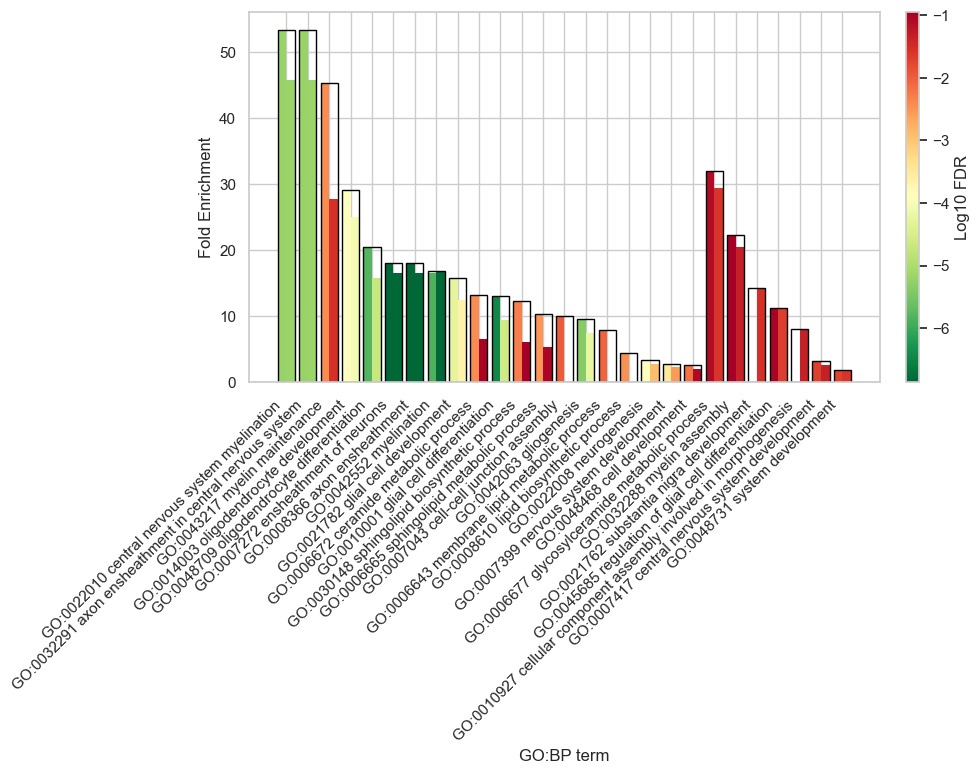

In [938]:
#produce comparative plots for functional enrichment

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle

# Load datasets
df_merged = df_merged2

# Compute logarithmic FDR values
df_merged['Log FDR_1'] = np.log10(df_merged['Enrichment FDR_1'] + 1e-10)  # Add small constant to avoid log(0)
df_merged['Log FDR_2'] = np.log10(df_merged['Enrichment FDR_2'] + 1e-10)  # Add small constant to avoid log(0)

# Define color maps for logarithmic FDR shading
cmap = cm.get_cmap('RdYlGn_r')
norm1 = Normalize(vmin=df_merged['Log FDR_1'].min(), vmax=df_merged['Log FDR_1'].max())
norm2 = Normalize(vmin=df_merged['Log FDR_2'].min(), vmax=df_merged['Log FDR_2'].max())

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Set bar width and positions
bar_width = 0.4
index = np.arange(len(df_merged.index))

# Plot bars for Dataset 1 (vertical bars)
colors1 = df_merged['Log FDR_1'].apply(lambda x: cmap(norm1(x)))
bars1 = ax.bar(index - bar_width/2, df_merged['Fold Enrichment_1'], bar_width, color=colors1, edgecolor='none', label='Saddlebrown')

# Plot bars for Dataset 2 (vertical bars)
colors2 = df_merged['Log FDR_2'].apply(lambda x: cmap(norm2(x)))
bars2 = ax.bar(index + bar_width/2, df_merged['Fold Enrichment_2'], bar_width, color=colors2, edgecolor='none', label='HC module AD')

# Add colorbars
sm1 = plt.cm.ScalarMappable(cmap=cmap, norm=norm1)
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=ax, orientation='vertical', fraction=0.02, pad=0.04, aspect=30)
cbar1.set_label('Log10 FDR')

# Draw borders around each pair of bars
for i in index:
    max_height = max(df_merged['Fold Enrichment_1'].iloc[i], df_merged['Fold Enrichment_2'].iloc[i])
    rect = Rectangle((i - bar_width, 0), 2 * bar_width, max_height, linewidth=1, edgecolor='black', facecolor='none')
    ax.add_patch(rect)

# Set labels and title
ax.set_ylabel('Fold Enrichment')
ax.set_xlabel('GO:BP term')

# Customize x-axis ticks and labels
ax.set_xticks(index)
ax.set_xticklabels(df_merged['Pathway_1'], rotation=45, ha='right')

# Show plot
plt.tight_layout()
fig.savefig("/Users/leonivandijk/Desktop/thesis/data/modules/HD/enrichment_blue.pdf", format='pdf', bbox_inches='tight')
plt.show()


In [424]:
df_merged2['pval_diff'] = df_merged2['Enrichment FDR_1'] - df_merged2['Enrichment FDR_2']

In [425]:
df_merged2[['Enrichment FDR_1', 'Enrichment FDR_2', 'pval_diff']] = np.round(df_merged2[['Enrichment FDR_1', 'Enrichment FDR_2', 'pval_diff']], 5)
changes = df_merged2.sort_values('pval_diff', ascending=False)[['Pathway_1', 'Enrichment FDR_1', 'Enrichment FDR_2', 'pval_diff']]

In [426]:
len(changes[changes['pval_diff']>0])

8

In [428]:
changes_ad

,Pathway_1,Enrichment FDR_1,Enrichment FDR_2,pval_diff
GO_term,,,,
GO:0007043,GO:0007043 cell-cell junction assembly,0.06883,0.01076,0.05807
GO:0043217,GO:0043217 myelin maintenance,0.03456,0.00377,0.03079
GO:0006643,GO:0006643 membrane lipid metabolic process,0.01897,0.00905,0.00993
GO:0008610,GO:0008610 lipid biosynthetic process,0.01115,0.00340,0.00774
GO:0006672,GO:0006672 ceramide metabolic process,0.00761,0.00377,0.00383
GO:0006665,GO:0006665 sphingolipid metabolic process,0.00385,0.00315,0.00070
GO:0010001,GO:0010001 glial cell differentiation,0.00002,0.00000,0.00002
GO:0021782,GO:0021782 glial cell development,0.00007,0.00005,0.00002
GO:0032291,GO:0032291 axon ensheathment in central nervou...,0.00000,0.00001,-0.00000


In [429]:
changes_HD

,Pathway_1,Enrichment FDR_1,Enrichment FDR_2,pval_diff
GO_term,,,,
GO:0010927,GO:0010927 cellular component assembly involve...,0.09078,0.04144,0.04934
GO:0006677,GO:0006677 glycosylceramide metabolic process,0.03456,0.01810,0.01646
GO:0032288,GO:0032288 myelin assembly,0.05688,0.04144,0.01544
GO:0043217,GO:0043217 myelin maintenance,0.03456,0.02051,0.01405
GO:0021782,GO:0021782 glial cell development,0.00007,0.00001,0.00007
GO:0010001,GO:0010001 glial cell differentiation,0.00002,0.00000,0.00002
GO:0042552,GO:0042552 myelination,0.00000,0.00000,0.00000
GO:0042063,GO:0042063 gliogenesis,0.00000,0.00000,0.00000
GO:0014003,GO:0014003 oligodendrocyte development,0.00001,0.00000,0.00000


In [410]:
list(changes.Pathway_1)

['GO:0010927 cellular component assembly involved in morphogenesis ',
 'GO:0006677 glycosylceramide metabolic process ',
 'GO:0032288 myelin assembly ',
 'GO:0043217 myelin maintenance ',
 'GO:0021782 glial cell development ',
 'GO:0010001 glial cell differentiation ',
 'GO:0042552 myelination ',
 'GO:0042063 gliogenesis ',
 'GO:0014003 oligodendrocyte development ',
 'GO:0007272 ensheathment of neurons ',
 'GO:0048709 oligodendrocyte differentiation ',
 'GO:0022010 central nervous system myelination ',
 'GO:0032291 axon ensheathment in central nervous system ',
 'GO:0008366 axon ensheathment ',
 'GO:0022008 neurogenesis ',
 'GO:0007399 nervous system development ',
 'GO:0045685 regulation of glial cell differentiation ',
 'GO:0048731 system development ',
 'GO:0007417 central nervous system development ',
 'GO:0048468 cell development ',
 'GO:0006665 sphingolipid metabolic process ',
 'GO:0048713 regulation of oligodendrocyte differentiation ',
 'GO:0030148 sphingolipid biosynthetic p

## Analysing required number of repetitions

In [530]:
counts_per_gene_ad = counts_per_gene_ad.reset_index()

In [532]:
counts_per_gene_hd = counts_per_gene_hd.reset_index()

In [534]:
AD_sizes_opt = []
HD_sizes_opt = []
for i in range(100, -1, -1): 
    ad = counts_per_gene_ad[counts_per_gene_ad['count']>=round(i*0.95)]
    AD_sizes_opt.append(ad.)

In [587]:
scenarios = AD

opt_sizes = []
n_hc_included = []
for i in range(100, -1, -1): 
    scenarios = AD[:i]
    genes, genedist = opt_modules_genes(scenarios)
    genedist = genedist.reset_index()
    consistent = genedist[genedist['count']>=round(i*0.95)]
    genes = list(genes[genes >= round(i*0.95)].index)
    count = 0
    for gene in genes:
        if gene in AD_OPT_RESULT:
            count = count + 1
    n_hc_included.append((i, count))
    opt_sizes.append((i,consistent.sum('index')[1]))

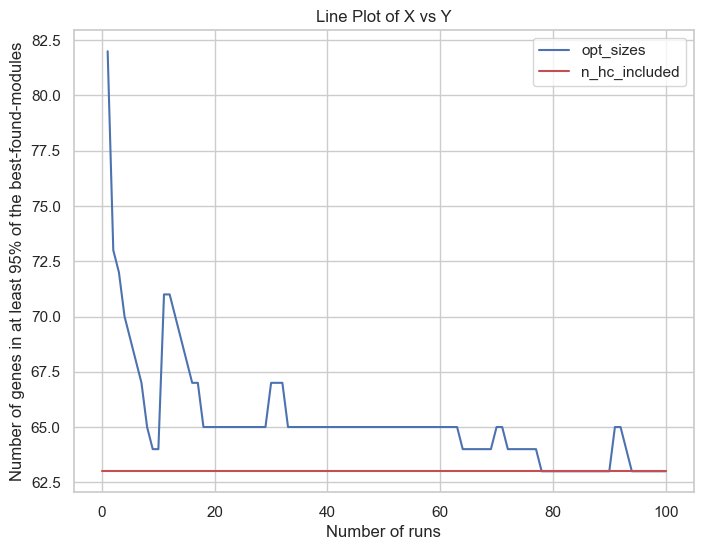

In [591]:
# Extract x and y values
x, y = zip(*opt_sizes[:-1])
x2, y2 = zip(*n_hc_included)

# Create the line plot
plt.figure(figsize=(8, 6))
plt.plot(x, y, linestyle='-', color='b', label='opt_sizes')
plt.plot(x2, y2, linestyle='-', color='r', label='n_hc_included')
plt.xlabel('Number of runs')
plt.ylabel('Number of genes in at least 95% of the best-found-modules')
plt.title('Line Plot of X vs Y')
plt.legend()
plt.grid(True)
plt.show()